#Data Labeling



##Libraries and connect to drive

In [ ]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
import re

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Performance datapreprocessing


###Attack

In [ ]:

import pandas as pd

file_path = '/content/drive/MyDrive/Master/R3_Mitre_Attack/Attack/Labeled/system_logs_labeled.csv'
df = pd.read_csv(file_path)

df['Timestamp'] = pd.to_datetime(df['Timestamp'])

df_diff = df.copy()

# Columns for which we will calculate the difference
columns_to_diff = ['Used Memory (MB)', 'CPU Load 1 min', 'CPU Load 5 min', 'CPU Load 15 min',
                   'Disk Usage (%)', 'TX (MB)', 'RX (MB)']

# Calculate the difference between consecutive rows
for col in columns_to_diff:
    df_diff[col + ' Diff'] = df[col].diff()

# Drop the first row since diff results in NaN for the first row
df_diff = df_diff.dropna().reset_index(drop=True)

# Include the original CPU usage values alongside their differences
df_diff['CPU Load 1 min Actual'] = df_diff['CPU Load 1 min']
df_diff['CPU Load 5 min Actual'] = df_diff['CPU Load 5 min']
df_diff['CPU Load 15 min Actual'] = df_diff['CPU Load 15 min']

# Retain only the relevant columns
columns_to_keep = ['Timestamp'] + [col + ' Diff' for col in columns_to_diff] + [
    'CPU Load 1 min Actual', 'CPU Load 5 min Actual', 'CPU Load 15 min Actual',
    'Open Ports', 'Label', 'Attack Technique'
]

df_final = df_diff[columns_to_keep]

# Relabel the specific time range
df_final.loc[
    (df_final['Timestamp'] >= '2024-08-24 23:52:00') &
    (df_final['Timestamp'] <= '2024-08-25 00:01:51'),
    ['Label', 'Attack Technique']
] = [1, 10]

# Save the simplified DataFrame to a new CSV file
output_file_path = '/content/drive/MyDrive/Master/R3_Mitre_Attack/Attack/ml/labeled_system_logs_diff.csv'
df_final.to_csv(output_file_path, index=False)

print(f"Processed logs with selected features have been saved to {output_file_path}")



Processed logs with selected features have been saved to /content/drive/MyDrive/Master/R3_Mitre_Attack/Attack/ml/labeled_system_logs_diff.csv


In [ ]:
#extract the data from the datalogger labeled log file


import pandas as pd

# Load the dataset
file_path = '/content/drive/MyDrive/Master/R3_Mitre_Attack/Attack/Labeled/datalogger_labeled.csv'
df = pd.read_csv(file_path)

# Construct the 'Timestamp' column from the individual date and time components
df['Timestamp'] = pd.to_datetime(
    df['Arp.Plc.Eclr/code.RTC_DT.YEAR'].astype(str) + '-' +
    df['Arp.Plc.Eclr/code.RTC_DT.MONTH'].astype(str).str.zfill(2) + '-' +
    df['Arp.Plc.Eclr/code.RTC_DT.DAY'].astype(str).str.zfill(2) + ' ' +
    df['Arp.Plc.Eclr/code.RTC_DT.HOURS'].astype(str).str.zfill(2) + ':' +
    df['Arp.Plc.Eclr/code.RTC_DT.MINUTES'].astype(str).str.zfill(2) + ':' +
    df['Arp.Plc.Eclr/code.RTC_DT.SECONDS'].astype(str).str.zfill(2)
)

# Remove unnecessary columns
columns_to_drop = [
    'Arp.Plc.Eclr/code.AXIO_ACT', 'Arp.Plc.Eclr/code.AXIO_BUS',
    'Arp.Plc.Eclr/code.AXIO_PF', 'Arp.Plc.Eclr/code.AXIO_PW',
    'Arp.Plc.Eclr/code.AXIO_RDY', 'Arp.Plc.Eclr/code.AXIO_RUN',
    'Arp.Plc.Eclr/code.AXIO_SYSFAIL', 'ConsistentDataSeries',
    'Arp.Plc.Eclr/code.RTC_DT.DAY', 'Arp.Plc.Eclr/code.RTC_DT.HOURS',
    'Arp.Plc.Eclr/code.RTC_DT.MINUTES', 'Arp.Plc.Eclr/code.RTC_DT.MONTH',
    'Arp.Plc.Eclr/code.RTC_DT.SECONDS', 'Arp.Plc.Eclr/code.RTC_DT.YEAR',
    'Arp.Plc.Eclr/code.USER_PART_DT.MEM_TOTAL', 'RecordAttribute'
]

df = df.drop(columns=columns_to_drop)

# Define the columns to average over every 50 rows
columns_to_average = [
    'Arp.Plc.Eclr/code.ESM_DATA1.ESM_INFOS[1].TASK_INFOS[1].LAST_ACTIVATION_DELAY',
    'Arp.Plc.Eclr/code.ESM_DATA1.ESM_INFOS[1].TASK_INFOS[1].LAST_EXEC_DURATION',
    'Arp.Plc.Eclr/code.IP_ACTIVE_DT',
    'Arp.Plc.Eclr/code.USER_PART_DT.MEM_FREE',
    'Arp.Plc.Eclr/code.USER_PART_DT.MEM_USAGE',
    'Arp.Plc.Eclr/code.ESM_DATA1.ESM_INFOS[2].TASK_INFOS[1].LAST_ACTIVATION_DELAY',
    'Arp.Plc.Eclr/code.USER_PART_DT.MEM_USED',
    'Arp.Plc.Eclr/code.cpu_1',
    'Arp.Plc.Eclr/code.cpu_2',
    'Arp.Plc.Eclr/code.temp',
    'Total_Exec_Duration',
    'Total_Activation_delay',
    'Arp.Plc.Eclr/code.ESM_DATA1.ESM_INFOS[2].TASK_INFOS[1].LAST_EXEC_DURATION'
]

# Function to process data in chunks of 50 rows
def process_in_chunks(df, chunk_size=50):
    processed_rows = []

    for start in range(0, len(df), chunk_size):
        chunk = df.iloc[start:start + chunk_size]

        if len(chunk) < chunk_size:
            continue  # Skip if the chunk is smaller than the chunk size

        # Compute the mean for the specified columns
        averaged_chunk = chunk[columns_to_average].mean().to_dict()

        # Get the label and attack technique from the last row in the chunk
        label = chunk.iloc[-1]['Label']
        attack_technique = chunk.iloc[-1]['Attack Technique']

        # Add timestamp from the last row
        timestamp = chunk.iloc[-1]['Timestamp']

        # Collect all other data into a dictionary
        new_row = {**averaged_chunk, 'Label': label, 'Attack Technique': attack_technique, 'Timestamp': timestamp}

        # Append to the list of processed rows
        processed_rows.append(new_row)

    return pd.DataFrame(processed_rows)

# Process the data
df_processed = process_in_chunks(df, chunk_size=50)

df_processed.loc[
    (df_processed['Timestamp'] >= '2024-08-24 23:51:00') &
    (df_processed['Timestamp'] <= '2024-08-25 00:01:51'),
    ['Label', 'Attack Technique']
] = [1, 10]


# Save the processed DataFrame to a CSV file
output_file_path = '/content/drive/MyDrive/Master/R3_Mitre_Attack/Attack/ml/labeled_dl_logs_diff.csv'
df_processed.to_csv(output_file_path, index=False)

print(f"Processed data has been saved to {output_file_path}")


Processed data has been saved to /content/drive/MyDrive/Master/R3_Mitre_Attack/Attack/ml/labeled_dl_logs_diff.csv


In [ ]:
import pandas as pd

# Load both CSV files into DataFrames
df1 = pd.read_csv('/content/drive/MyDrive/Master/R3_Mitre_Attack/Attack/ml/labeled_system_logs_diff.csv')
df2 = pd.read_csv('/content/drive/MyDrive/Master/R3_Mitre_Attack/Attack/ml/labeled_dl_logs_diff.csv')

# Ensure Timestamp is in datetime format for proper merging
df1['Timestamp'] = pd.to_datetime(df1['Timestamp'])
df2['Timestamp'] = pd.to_datetime(df2['Timestamp'])

# Sort by Timestamp to use merge_asof
df1.sort_values('Timestamp', inplace=True)
df2.sort_values('Timestamp', inplace=True)

# Merge df1 with df2 based on the nearest Timestamp
df_combined = pd.merge_asof(df1, df2, on='Timestamp', direction='nearest', suffixes=('', '_dl'))

# Replace the Timestamp in df_combined with the Timestamp from df1
df_combined['Timestamp'] = df1['Timestamp'].reset_index(drop=True)

# Remove the old Label and Attack Technique columns
df_combined = df_combined.drop(columns=['Label', 'Attack Technique'])

# Rename Label_dl and Attack Technique_dl to Label and Attack Technique
df_combined.rename(columns={'Label_dl': 'Label', 'Attack Technique_dl': 'Attack Technique'}, inplace=True)

df_combined['Timestamp'] = df_combined['Timestamp'].diff().fillna(pd.Timedelta(seconds=0)).dt.total_seconds().cumsum()


# Save the combined DataFrame to a new CSV file
output_file_path = '/content/drive/MyDrive/Master/R3_Mitre_Attack/Attack/ml/combined_data.csv'
df_combined.to_csv(output_file_path, index=False)

print(f"Combined data has been saved to {output_file_path}")

Combined data has been saved to /content/drive/MyDrive/Master/R3_Mitre_Attack/Attack/ml/combined_data.csv


### Normal Operation


In [ ]:
#extract the data from the system labeled log file

import pandas as pd

# Load the dataset
file_path = '/content/drive/MyDrive/Master/R3_Mitre_Attack/Normal/Labeled/system_label.csv'
df = pd.read_csv(file_path)

# Convert Timestamp to datetime for easier manipulation
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Create a new DataFrame for the differences
df_diff = df.copy()

# Columns for which we will calculate the difference
columns_to_diff = ['Used Memory (MB)', 'CPU Load 1 min', 'CPU Load 5 min', 'CPU Load 15 min',
                   'Disk Usage (%)', 'TX (MB)', 'RX (MB)']

# Calculate the difference between consecutive rows
for col in columns_to_diff:
    df_diff[col + ' Diff'] = df[col].diff()

# Drop the first row since diff results in NaN for the first row
df_diff = df_diff.dropna().reset_index(drop=True)

# Include the original CPU usage values alongside their differences
df_diff['CPU Load 1 min Actual'] = df_diff['CPU Load 1 min']
df_diff['CPU Load 5 min Actual'] = df_diff['CPU Load 5 min']
df_diff['CPU Load 15 min Actual'] = df_diff['CPU Load 15 min']

# Retain only the relevant columns
columns_to_keep = ['Timestamp'] + [col + ' Diff' for col in columns_to_diff] + [
    'CPU Load 1 min Actual', 'CPU Load 5 min Actual', 'CPU Load 15 min Actual',
    'Open Ports', 'Label', 'Attack Technique'
]

df_final = df_diff[columns_to_keep]


# Save the simplified DataFrame to a new CSV file
output_file_path = '/content/drive/MyDrive/Master/R3_Mitre_Attack/Normal/ml/labeled_system_logs_diff.csv'
df_final.to_csv(output_file_path, index=False)

print(f"Processed logs with selected features have been saved to {output_file_path}")


Processed logs with selected features have been saved to /content/drive/MyDrive/Master/R3_Mitre_Attack/Normal/ml/labeled_system_logs_diff.csv


In [ ]:
import pandas as pd

# Load the dataset
file_path = '/content/drive/MyDrive/Master/R3_Mitre_Attack/Normal/Labeled/datalogger_labeled.csv'
df = pd.read_csv(file_path)

# Construct the 'Timestamp' column from the individual date and time components
df['Timestamp'] = pd.to_datetime(
    df['Arp.Plc.Eclr/code.RTC_DT.YEAR'].astype(str) + '-' +
    df['Arp.Plc.Eclr/code.RTC_DT.MONTH'].astype(str).str.zfill(2) + '-' +
    df['Arp.Plc.Eclr/code.RTC_DT.DAY'].astype(str).str.zfill(2) + ' ' +
    df['Arp.Plc.Eclr/code.RTC_DT.HOURS'].astype(str).str.zfill(2) + ':' +
    df['Arp.Plc.Eclr/code.RTC_DT.MINUTES'].astype(str).str.zfill(2) + ':' +
    df['Arp.Plc.Eclr/code.RTC_DT.SECONDS'].astype(str).str.zfill(2)
)

# Remove unnecessary columns
columns_to_drop = [
    'Arp.Plc.Eclr/code.AXIO_ACT', 'Arp.Plc.Eclr/code.AXIO_BUS',
    'Arp.Plc.Eclr/code.AXIO_PF', 'Arp.Plc.Eclr/code.AXIO_PW',
    'Arp.Plc.Eclr/code.AXIO_RDY', 'Arp.Plc.Eclr/code.AXIO_RUN',
    'Arp.Plc.Eclr/code.AXIO_SYSFAIL', 'ConsistentDataSeries',
    'Arp.Plc.Eclr/code.RTC_DT.DAY', 'Arp.Plc.Eclr/code.RTC_DT.HOURS',
    'Arp.Plc.Eclr/code.RTC_DT.MINUTES', 'Arp.Plc.Eclr/code.RTC_DT.MONTH',
    'Arp.Plc.Eclr/code.RTC_DT.SECONDS', 'Arp.Plc.Eclr/code.RTC_DT.YEAR',
    'Arp.Plc.Eclr/code.USER_PART_DT.MEM_TOTAL', 'RecordAttribute'
]

df = df.drop(columns=columns_to_drop)

# Define the columns to average over every 50 rows
columns_to_average = [
    'Arp.Plc.Eclr/code.ESM_DATA1.ESM_INFOS[1].TASK_INFOS[1].LAST_ACTIVATION_DELAY',
    'Arp.Plc.Eclr/code.ESM_DATA1.ESM_INFOS[1].TASK_INFOS[1].LAST_EXEC_DURATION',
    'Arp.Plc.Eclr/code.IP_ACTIVE_DT',
    'Arp.Plc.Eclr/code.USER_PART_DT.MEM_FREE',
    'Arp.Plc.Eclr/code.USER_PART_DT.MEM_USAGE',
    'Arp.Plc.Eclr/code.ESM_DATA1.ESM_INFOS[2].TASK_INFOS[1].LAST_ACTIVATION_DELAY',
    'Arp.Plc.Eclr/code.USER_PART_DT.MEM_USED',
    'Arp.Plc.Eclr/code.cpu_1',
    'Arp.Plc.Eclr/code.cpu_2',
    'Arp.Plc.Eclr/code.temp',
    'Total_Exec_Duration',
    'Total_Activation_delay',
    'Arp.Plc.Eclr/code.ESM_DATA1.ESM_INFOS[2].TASK_INFOS[1].LAST_EXEC_DURATION'
]

# Function to process data in chunks of 50 rows
def process_in_chunks(df, chunk_size=50):
    processed_rows = []

    for start in range(0, len(df), chunk_size):
        chunk = df.iloc[start:start + chunk_size]

        if len(chunk) < chunk_size:
            continue  # Skip if the chunk is smaller than the chunk size

        # Compute the mean for the specified columns
        averaged_chunk = chunk[columns_to_average].mean().to_dict()

        # Set the label and attack technique to 0, 0 for normal operation
        label = 0
        attack_technique = 0

        # Add timestamp from the last row
        timestamp = chunk.iloc[-1]['Timestamp']

        # Collect all other data into a dictionary
        new_row = {**averaged_chunk, 'Label': label, 'Attack Technique': attack_technique, 'Timestamp': timestamp}

        # Append to the list of processed rows
        processed_rows.append(new_row)

    return pd.DataFrame(processed_rows)

# Process the data
df_processed = process_in_chunks(df, chunk_size=50)

# Save the processed DataFrame to a CSV file
output_file_path = '/content/drive/MyDrive/Master/R3_Mitre_Attack/Normal/ml/labeled_dl_logs_diff.csv'
df_processed.to_csv(output_file_path, index=False)

print(f"Processed data has been saved to {output_file_path}")



Processed data has been saved to /content/drive/MyDrive/Master/R3_Mitre_Attack/Normal/ml/labeled_dl_logs_diff.csv


In [ ]:
import pandas as pd

# Load both CSV files into DataFrames
df1 = pd.read_csv('/content/drive/MyDrive/Master/R3_Mitre_Attack/Normal/ml/labeled_system_logs_diff.csv')
df2 = pd.read_csv('/content/drive/MyDrive/Master/R3_Mitre_Attack/Normal/ml/labeled_dl_logs_diff.csv')

# Ensure Timestamp is in datetime format for proper merging
df1['Timestamp'] = pd.to_datetime(df1['Timestamp'])
df2['Timestamp'] = pd.to_datetime(df2['Timestamp'])

# Sort by Timestamp to use merge_asof
df1.sort_values('Timestamp', inplace=True)
df2.sort_values('Timestamp', inplace=True)

# Merge df1 with df2 based on the nearest Timestamp
df_combined = pd.merge_asof(df1, df2, on='Timestamp', direction='nearest', suffixes=('', '_dl'))

# Replace the Timestamp in df_combined with the Timestamp from df1
df_combined['Timestamp'] = df1['Timestamp'].reset_index(drop=True)

# Remove the old Label and Attack Technique columns
df_combined = df_combined.drop(columns=['Label', 'Attack Technique'])

# Rename Label_dl and Attack Technique_dl to Label and Attack Technique
df_combined.rename(columns={'Label_dl': 'Label', 'Attack Technique_dl': 'Attack Technique'}, inplace=True)

df_combined['Timestamp'] = df_combined['Timestamp'].diff().fillna(pd.Timedelta(seconds=0)).dt.total_seconds().cumsum()

df_combined = df_combined[24:]

# Save the combined DataFrame to a new CSV file
output_file_path = '/content/drive/MyDrive/Master/R3_Mitre_Attack/Normal/ml/combined_data.csv'
df_combined.to_csv(output_file_path, index=False)

print(f"Combined data has been saved to {output_file_path}")

Combined data has been saved to /content/drive/MyDrive/Master/R3_Mitre_Attack/Normal/ml/combined_data.csv


##Merg of Normal and Attack

In [ ]:
import pandas as pd

# Load both CSV files into DataFrames
df1 = pd.read_csv('/content/drive/MyDrive/Master/R3_Mitre_Attack/Normal/ml/combined_data.csv')
df2 = pd.read_csv('/content/drive/MyDrive/Master/R3_Mitre_Attack/Attack/ml/Perf_dataset.csv')

# Append df2 to df1
df_perf = pd.concat([df1, df2], ignore_index=True)

# Save the combined DataFrame to a new CSV file
output_file_path = '/content/drive/MyDrive/Master/R3_Mitre_Attack/Final_Dataset/perf_dataset.csv'
df_perf.to_csv(output_file_path, index=False)

In [ ]:
df_perf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1357 entries, 0 to 1356
Data columns (total 27 columns):
 #   Column                                                                        Non-Null Count  Dtype  
---  ------                                                                        --------------  -----  
 0   Timestamp                                                                     1357 non-null   float64
 1   Used Memory (MB) Diff                                                         1357 non-null   float64
 2   CPU Load 1 min Diff                                                           1357 non-null   float64
 3   CPU Load 5 min Diff                                                           1357 non-null   float64
 4   CPU Load 15 min Diff                                                          1357 non-null   float64
 5   Disk Usage (%) Diff                                                           1357 non-null   float64
 6   TX (MB) Diff                    

###Preparing Event merge

In [ ]:
import pandas as pd

# Define the file paths
file_paths = {
    "security_labeled.csv": 1,
    "Output_labeled.csv": 1,
    "default_labeled.csv": 1, #"all_network_logs_labeled.csv": 2,
    "all_logs_labeled.csv": 2
}

base_path = "/content/drive/MyDrive/Master/R3_Mitre_Attack/Attack/Labeled"

# Initialize an empty list to hold all data
all_data = []

# Loop through each file and load it with the appropriate data-type label
for file_name, data_type in file_paths.items():
    # Load the CSV file
    df = pd.read_csv(f"{base_path}/{file_name}")

    # Add the data-type column
    df['data-type'] = data_type

    # Append the data to the list
    all_data.append(df)

# Concatenate all data into a single DataFrame
df_combined = pd.concat(all_data, ignore_index=True)

# Ensure that only 'Message', 'Label', 'Attack Technique', and 'data-type' columns are retained
columns_to_keep = ['Message', 'Label', 'Attack Technique', 'data-type']

# If 'Output_label.csv' has an additional 'Label' column, merge it correctly
if 'Label' in df_combined.columns:
    df_combined['Label'] = df_combined['Label'].fillna(0).astype(int)  # Ensure Label column is consistent

df_combined = df_combined[columns_to_keep]

# Save the combined DataFrame to a new CSV file
output_file_path = "/content/drive/MyDrive/Master/R3_Mitre_Attack/Attack/experiment/combined_events.csv"
df_combined.to_csv(output_file_path, index=False)

print(f"Combined data has been saved to {output_file_path}")


Combined data has been saved to /content/drive/MyDrive/Master/R3_Mitre_Attack/Attack/experiment/combined_events.csv


In [ ]:
import pandas as pd

# Define the file paths
file_paths = {
    "security_labeled.csv": 1,
    "output_label.csv": 1,
    "default_labeled.csv": 1,
    "event_logs_label.csv": 2 #,"network_logs_label.csv": 2
}

base_path = "/content/drive/MyDrive/Master/R3_Mitre_Attack/Normal/Labeled"

# Initialize an empty list to hold all data
all_data = []

# Loop through each file and load it with the appropriate data-type label
for file_name, data_type in file_paths.items():
    # Load the CSV file
    df = pd.read_csv(f"{base_path}/{file_name}")

    # Add the data-type column
    df['data-type'] = data_type

    # Append the data to the list
    all_data.append(df)

# Concatenate all data into a single DataFrame
df_combined = pd.concat(all_data, ignore_index=True)

# Ensure that only 'Message', 'Label', 'Attack Technique', and 'data-type' columns are retained
columns_to_keep = ['Message', 'Label', 'Attack Technique', 'data-type']

# If 'Output_label.csv' has an additional 'Label' column, merge it correctly
if 'Label' in df_combined.columns:
    df_combined['Label'] = df_combined['Label'].fillna(0).astype(int)  # Ensure Label column is consistent

df_combined = df_combined[columns_to_keep]

# Save the combined DataFrame to a new CSV file
output_file_path = "/content/drive/MyDrive/Master/R3_Mitre_Attack/Normal/ml/combined_events.csv"
df_combined.to_csv(output_file_path, index=False)

print(f"Combined data has been saved to {output_file_path}")

Combined data has been saved to /content/drive/MyDrive/Master/R3_Mitre_Attack/Normal/ml/combined_events.csv


In [ ]:
import pandas as pd

# Load the two additional CSV files
df_normal = pd.read_csv("/content/drive/MyDrive/Master/R3_Mitre_Attack/Normal/ml/combined_events.csv")
df_attack = pd.read_csv("/content/drive/MyDrive/Master/R3_Mitre_Attack/Attack/experiment/combined_events.csv")

# Ensure that both new files have the same columns as the combined logs
columns_to_keep = ['Message', 'Label', 'Attack Technique', 'data-type']
df_normal = df_normal[columns_to_keep]
df_attack = df_attack[columns_to_keep]

# Concatenate the new data with the existing combined data
df_event = pd.concat([df_combined, df_normal, df_attack], ignore_index=True)

# Save the final combined DataFrame to a new CSV file
final_output_path = "/content/drive/MyDrive/Master/R3_Mitre_Attack/Final_Dataset/event_logs.csv"
df_event.to_csv(final_output_path, index=False)

print(f"Final combined data has been saved to {final_output_path}")


Final combined data has been saved to /content/drive/MyDrive/Master/R3_Mitre_Attack/Final_Dataset/event_logs.csv


In [ ]:
import pandas as pd

# Create a dictionary to map attack technique numbers to names
technique_mapping = {
    0: "No Technique",
    1: "Exploit Public-Facing Application (T0819)",
    2: "Command-Line Interface (T0807)",
    3: "Modify Program (T0889)",
    4: "Exploit Privilege Escalation (T0890)",
    5: "Exploit for Evasion (T0820)",
    6: "Change Operating Mode (T0858)",
    7: "Network Connection Enumeration (T0840)",
    8: "Valid Accounts (T0859)",
    9: "Detect Operating Mode (T0868)",
    10: "Standard Application Layer Protocol (T0869)",
    11: "Change Credential (T0892)",
    12: "Service Stop (T0881)",
    13: "Modify Parameter (T0836)",
    14: "Loss of Control (T0827)"
}

# Apply the technique names to the dataset
df_event['Attack Technique Name'] = df_event['Attack Technique'].map(technique_mapping)

# Group by 'Attack Technique Name' and 'data-type' to get the counts of each technique in each log type
log_type_counts = df_event.groupby(['Attack Technique Name', 'data-type']).size().unstack(fill_value=0)

# Reset index and rename the columns
log_type_counts.reset_index(inplace=True)
log_type_counts.columns = ['Attack Technique', 'Application Logs (1)', 'Syslog (2)']

# Reorder the table to match the logical flow of the attack chain
attack_order = [
    "No Technique",
    "Exploit Public-Facing Application (T0819)",
    "Command-Line Interface (T0807)",
    "Modify Program (T0889)",
    "Exploit Privilege Escalation (T0890)",
    "Exploit for Evasion (T0820)",
    "Change Operating Mode (T0858)",
    "Network Connection Enumeration (T0840)",
    "Valid Accounts (T0859)",
    "Detect Operating Mode (T0868)",
    "Standard Application Layer Protocol (T0869)",
    "Change Credential (T0892)",
    "Service Stop (T0881)",
    "Modify Parameter (T0836)",
    "Loss of Control (T0827)"
]

log_type_counts['Attack Technique'] = pd.Categorical(log_type_counts['Attack Technique'], categories=attack_order, ordered=True)
log_type_counts.sort_values('Attack Technique', inplace=True)

# Display the ordered table
log_type_counts


,Attack Technique,Application Logs (1),Syslog (2)
9,No Technique,3729,14607
2,Command-Line Interface (T0807),0,179
7,Modify Program (T0889),0,3
4,Exploit Privilege Escalation (T0890),0,286
5,Exploit for Evasion (T0820),287,34
1,Change Operating Mode (T0858),55,335
8,Network Connection Enumeration (T0840),0,38
12,Valid Accounts (T0859),0,3
3,Detect Operating Mode (T0868),0,28
11,Standard Application Layer Protocol (T0869),0,1


In [ ]:
db_path = '/content/drive/MyDrive/Master/R3_Mitre_Attack/perf_log_attack.db'

conn = sqlite3.connect(db_path)

query = 'SELECT * FROM log_all_810429887'

df = pd.read_sql_query(query, conn)

df['datetime'] = pd.to_datetime(
    df['Arp.Plc.Eclr/code.RTC_DT.YEAR'].astype(str) + '-' +
    df['Arp.Plc.Eclr/code.RTC_DT.MONTH'].astype(str).str.zfill(2) + '-' +
    df['Arp.Plc.Eclr/code.RTC_DT.DAY'].astype(str).str.zfill(2) + ' ' +
    df['Arp.Plc.Eclr/code.RTC_DT.HOURS'].astype(str).str.zfill(2) + ':' +
    df['Arp.Plc.Eclr/code.RTC_DT.MINUTES'].astype(str).str.zfill(2) + ':' +
    df['Arp.Plc.Eclr/code.RTC_DT.SECONDS'].astype(str).str.zfill(2)
)

time_filter = (
    ((df['Arp.Plc.Eclr/code.RTC_DT.HOURS'] == 21) & (df['Arp.Plc.Eclr/code.RTC_DT.MINUTES'] >= 57)) |
    (df['Arp.Plc.Eclr/code.RTC_DT.HOURS'] == 22) |
    (df['Arp.Plc.Eclr/code.RTC_DT.HOURS'] == 23) |
    ((df['Arp.Plc.Eclr/code.RTC_DT.HOURS'] == 0) & (df['Arp.Plc.Eclr/code.RTC_DT.MINUTES'] <= 10))
)

df_logging_attack = df[time_filter].reset_index(drop=True)

df_logging_attack['Total_Exec_Duration'] = (
    df_logging_attack['Arp.Plc.Eclr/code.ESM_DATA1.ESM_INFOS[1].TASK_INFOS[1].LAST_EXEC_DURATION'] +
    df_logging_attack['Arp.Plc.Eclr/code.ESM_DATA1.ESM_INFOS[2].TASK_INFOS[1].LAST_EXEC_DURATION']
)

df_logging_attack['Total_Activation_delay'] = (
    df_logging_attack['Arp.Plc.Eclr/code.ESM_DATA1.ESM_INFOS[1].TASK_INFOS[1].LAST_ACTIVATION_DELAY'] +
    df_logging_attack['Arp.Plc.Eclr/code.ESM_DATA1.ESM_INFOS[2].TASK_INFOS[1].LAST_ACTIVATION_DELAY']
)

df_logging_attack.to_csv('/content/drive/MyDrive/Master/R1_Performance/perf_DB_logging_attack.csv', index=False)

conn.close()

In [ ]:
df_logging_attack.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75248 entries, 0 to 75247
Data columns (total 24 columns):
 #   Column                                                                        Non-Null Count  Dtype         
---  ------                                                                        --------------  -----         
 0   Timestamp                                                                     75248 non-null  int64         
 1   ConsistentDataSeries                                                          75248 non-null  int64         
 2   Arp.Plc.Eclr/code.ESM_DATA1.ESM_INFOS[1].TASK_INFOS[1].LAST_ACTIVATION_DELAY  75248 non-null  int64         
 3   Arp.Plc.Eclr/code.ESM_DATA1.ESM_INFOS[1].TASK_INFOS[1].LAST_EXEC_DURATION     75248 non-null  int64         
 4   Arp.Plc.Eclr/code.ESM_DATA1.ESM_INFOS[2].TASK_INFOS[1].LAST_ACTIVATION_DELAY  75248 non-null  int64         
 5   Arp.Plc.Eclr/code.ESM_DATA1.ESM_INFOS[2].TASK_INFOS[1].LAST_EXEC_DURATION     75248 non-

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Dictionary to map attack technique numbers to names
technique_mapping = {
    0: "No Technique",
    1: "Exploit Public-Facing Application (T0819)",
    2: "Command-Line Interface (T0807)",
    3: "Modify Program (T0889)",
    4: "Exploit Privilege Escalation (T0890)",
    5: "Exploit for Evasion (T0820)",
    6: "Change Operating Mode (T0858)",
    7: "Network Connection Enumeration (T0840)",
    8: "Valid Accounts (T0859)",
    9: "Detect Operating Mode (T0868)",
    10: "Standard Application Layer Protocol (T0869)",
    11: "Change Credential (T0892)",
    12: "Service Stop (T0881)",
    13: "Modify Parameter (T0836)",
    14: "Loss of Control (T0827)"
}

# Attack time frames
attack_timeframes = [
    ("2024-08-24 21:59", "2024-08-24 22:02", 1),
    ("2024-08-24 22:03", "2024-08-24 22:24", 2),
    ("2024-08-24 22:25", "2024-08-24 22:27", 3),
    ("2024-08-24 22:28", "2024-08-24 22:59", 4),
    ("2024-08-24 23:00", "2024-08-24 23:06", 5),
    ("2024-08-24 23:07", "2024-08-24 23:09", 6),
    ("2024-08-24 23:10", "2024-08-24 23:19", 7),
    ("2024-08-24 23:20", "2024-08-24 23:22", 8),
    ("2024-08-24 23:23", "2024-08-24 23:28", 9),
    ("2024-08-24 23:29", "2024-08-24 23:50", 10),
    ("2024-08-24 23:51", "2024-08-24 23:53", 11),
    ("2024-08-24 23:54", "2024-08-25 00:01", 12),
    ("2024-08-25 00:02", "2024-08-25 00:05", 13)
]

# Create CPU usage by averaging 'cpu_1' and 'cpu_2'
df_logging_attack['cpu_usage'] = (df_logging_attack['Arp.Plc.Eclr/code.cpu_1'] + df_logging_attack['Arp.Plc.Eclr/code.cpu_2']) / 2

# Use the 'MEM_USED' column for memory usage
df_logging_attack['memory_usage'] = df_logging_attack['Arp.Plc.Eclr/code.USER_PART_DT.MEM_USED']

# Create an empty DataFrame to store max, mean, and added values for each technique
performance_stats = []

for start_time, end_time, technique in attack_timeframes:
    # Filter the dataset based on the start and end time for each technique
    mask = (df_logging_attack['datetime'].dt.time >= pd.to_datetime(start_time).time()) & (df_logging_attack['datetime'].dt.time <= pd.to_datetime(end_time).time())
    filtered_df = df_logging_attack[mask]

    if not filtered_df.empty:
        # Calculate max and mean values for CPU usage
        max_cpu = filtered_df['cpu_usage'].max()
        mean_cpu = filtered_df['cpu_usage'].mean()

        # Calculate the added memory usage (difference between last and first memory value)
        added_memory = filtered_df['memory_usage'].iloc[-1] - filtered_df['memory_usage'].iloc[0]

        # Store the results
        performance_stats.append({
            'Technique': technique_mapping[technique],
            'Max CPU Usage': max_cpu,
            'Mean CPU Usage': mean_cpu,
            'Added Memory Usage': added_memory  # Add the memory difference
        })

# Convert performance stats to DataFrame for easier visualization
performance_df = pd.DataFrame(performance_stats)

# Display the performance data
performance_df


,Technique,Max CPU Usage,Mean CPU Usage,Added Memory Usage
0,Exploit Public-Facing Application (T0819),89.0,17.508564,311296
1,Command-Line Interface (T0807),99.5,36.920731,4141056
2,Modify Program (T0889),98.5,16.766116,163840
3,Exploit Privilege Escalation (T0890),100.0,24.116879,85770240
4,Exploit for Evasion (T0820),99.0,21.511631,483328
5,Change Operating Mode (T0858),91.5,37.266467,-135168
6,Network Connection Enumeration (T0840),99.0,25.253744,815104
7,Valid Accounts (T0859),99.0,26.466088,188416
8,Detect Operating Mode (T0868),100.0,30.032890,499712
9,Standard Application Layer Protocol (T0869),100.0,22.291554,14520320


<ipython-input-12-c31d06380e71>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Technique', y='Max CPU Usage', data=performance_df, palette='Blues_d')


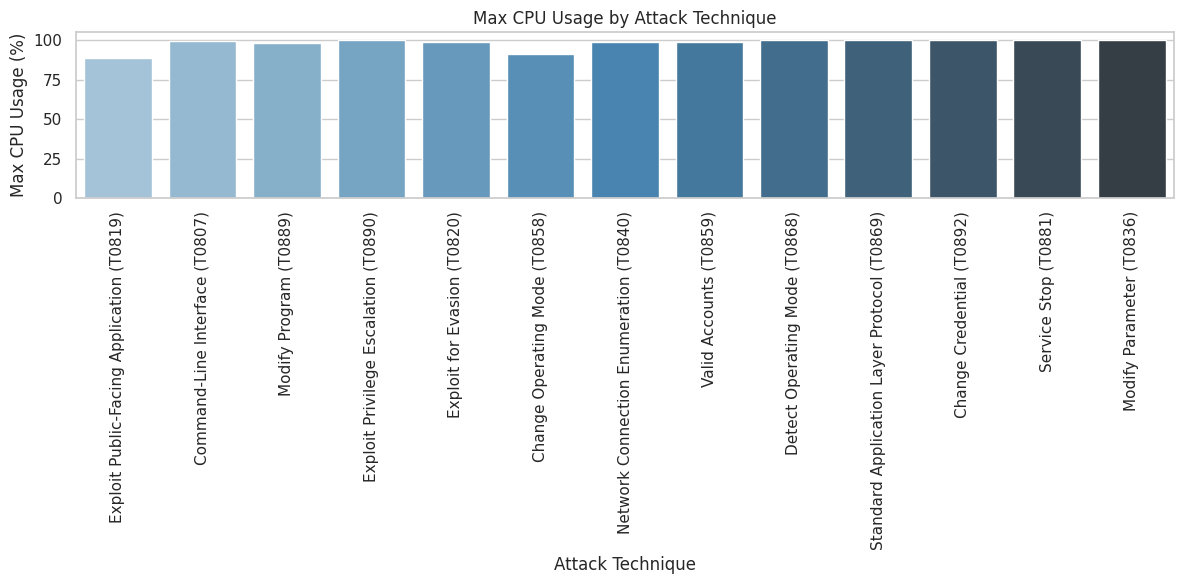

<ipython-input-12-c31d06380e71>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Technique', y='Mean CPU Usage', data=performance_df, palette='Greens_d')


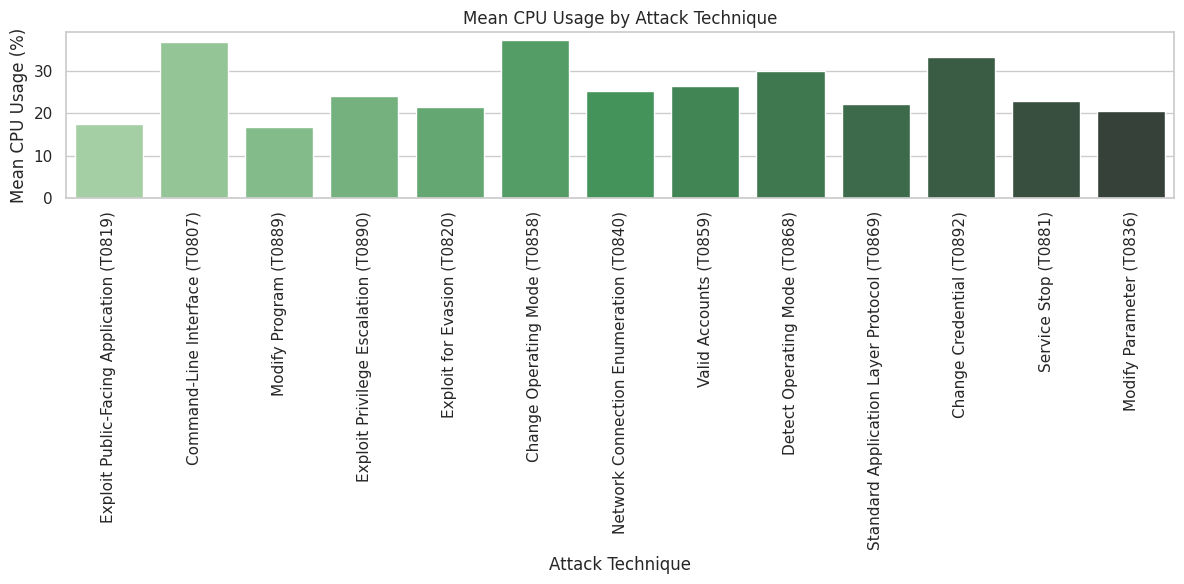

<ipython-input-12-c31d06380e71>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Technique', y='Added Memory Usage', data=performance_df, palette='Oranges_d')


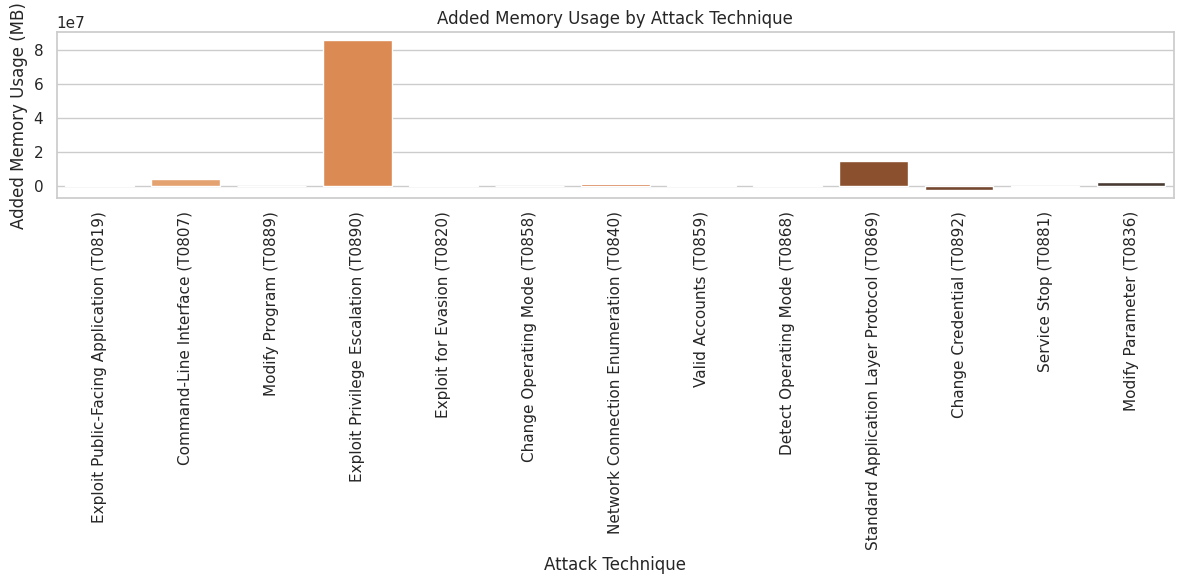

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plotting style
sns.set(style="whitegrid")

# Plot Max CPU Usage by Technique
plt.figure(figsize=(12, 6))
sns.barplot(x='Technique', y='Max CPU Usage', data=performance_df, palette='Blues_d')
plt.xticks(rotation=90)
plt.title('Max CPU Usage by Attack Technique')
plt.xlabel('Attack Technique')
plt.ylabel('Max CPU Usage (%)')
plt.tight_layout()
plt.show()

# Plot Mean CPU Usage by Technique
plt.figure(figsize=(12, 6))
sns.barplot(x='Technique', y='Mean CPU Usage', data=performance_df, palette='Greens_d')
plt.xticks(rotation=90)
plt.title('Mean CPU Usage by Attack Technique')
plt.xlabel('Attack Technique')
plt.ylabel('Mean CPU Usage (%)')
plt.tight_layout()
plt.show()

# Plot Added Memory Usage by Technique
plt.figure(figsize=(12, 6))
sns.barplot(x='Technique', y='Added Memory Usage', data=performance_df, palette='Oranges_d')
plt.xticks(rotation=90)
plt.title('Added Memory Usage by Attack Technique')
plt.xlabel('Attack Technique')
plt.ylabel('Added Memory Usage (MB)')
plt.tight_layout()
plt.show()


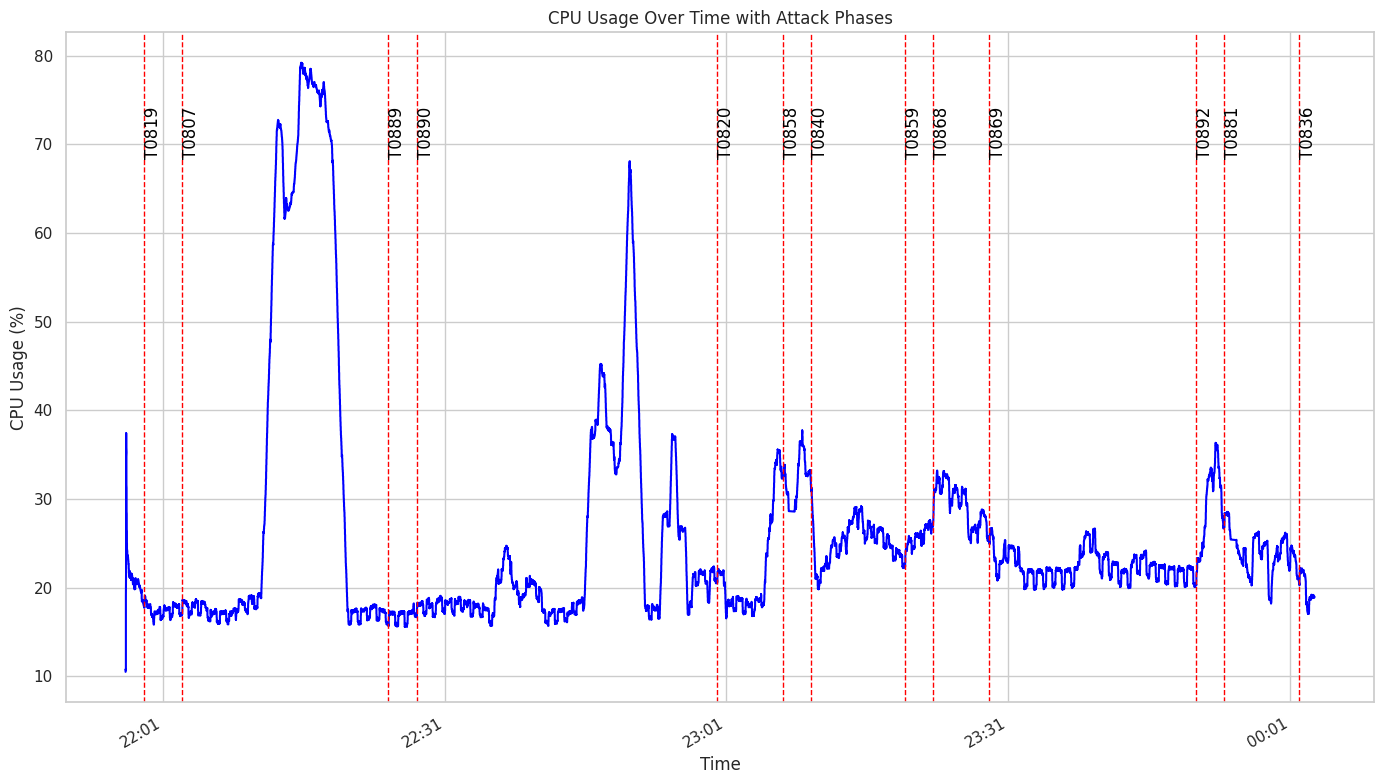

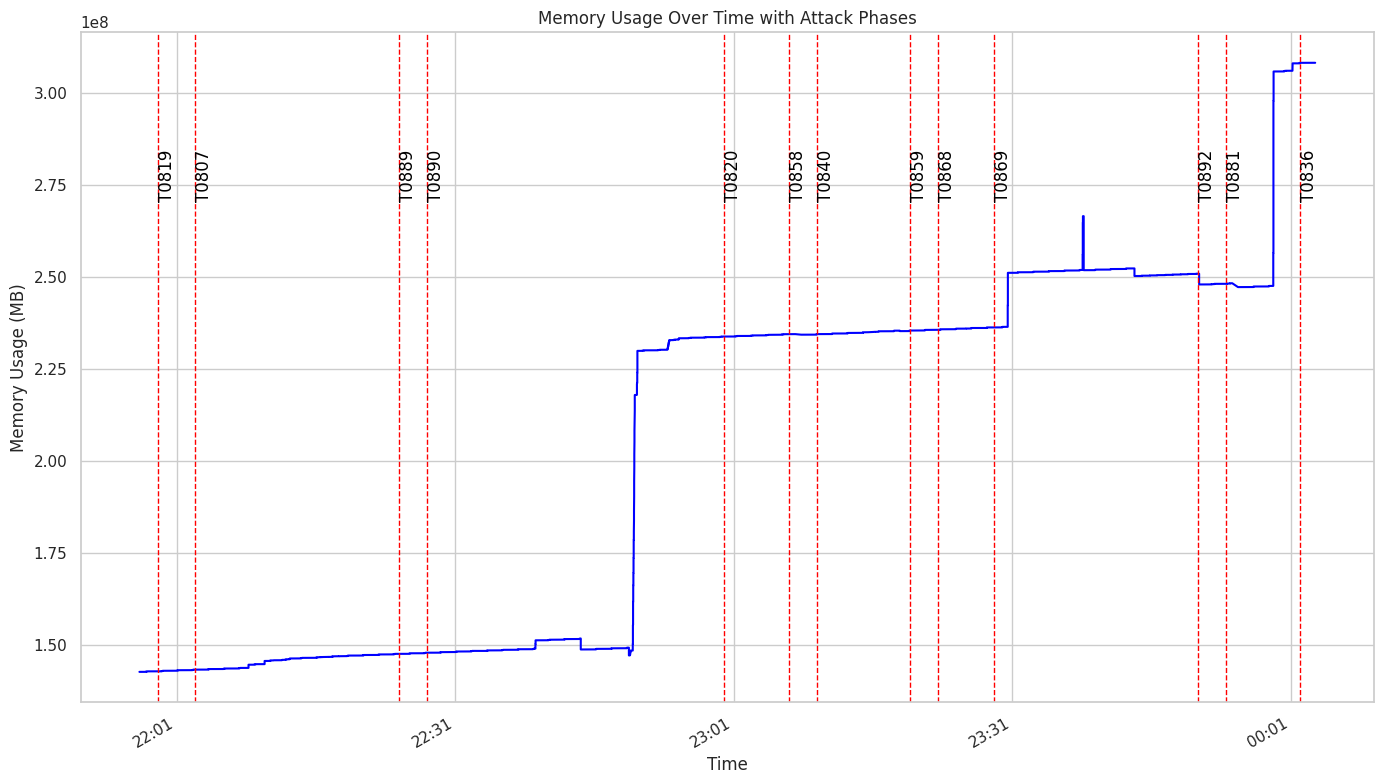

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Attack time frames, handling the date change at midnight
attack_timeframes = [
    ("2024-08-24 21:59", "2024-08-24 22:02", "T0819"),
    ("2024-08-24 22:03", "2024-08-24 22:24", "T0807"),
    ("2024-08-24 22:25", "2024-08-24 22:27", "T0889"),
    ("2024-08-24 22:28", "2024-08-24 22:59", "T0890"),
    ("2024-08-24 23:00", "2024-08-24 23:06", "T0820"),
    ("2024-08-24 23:07", "2024-08-24 23:09", "T0858"),
    ("2024-08-24 23:10", "2024-08-24 23:19", "T0840"),
    ("2024-08-24 23:20", "2024-08-24 23:22", "T0859"),
    ("2024-08-24 23:23", "2024-08-24 23:28", "T0868"),
    ("2024-08-24 23:29", "2024-08-24 23:50", "T0869"),
    ("2024-08-24 23:51", "2024-08-24 23:53", "T0892"),
    ("2024-08-24 23:54", "2024-08-25 00:01", "T0881"),
    ("2024-08-25 00:02", "2024-08-25 00:05", "T0836")
]

# Convert the 'datetime' column to actual datetime objects
df_logging_attack['datetime'] = pd.to_datetime(df_logging_attack['datetime'])

# Filter the data to only include entries from August 24 and 25, 2024
df_logging_attack = df_logging_attack[df_logging_attack['datetime'].dt.date.isin([pd.to_datetime('2024-08-24').date(), pd.to_datetime('2024-08-25').date()])]

# Smoothing function using rolling average (window size 10 for stronger smoothing)
df_logging_attack['smoothed_cpu_usage'] = df_logging_attack['cpu_usage'].rolling(window=1000, min_periods=1).mean()

# Plotting CPU and Memory usage with vertical lines for attack phases
def plot_performance_with_attacks(data, metric, ylabel, title, smoothing=False):
    plt.figure(figsize=(14, 8))

    # Apply smoothing if specified
    if smoothing:
        metric = 'smoothed_' + metric

    # Plot the performance metric over time
    plt.plot(data['datetime'], data[metric], label=f'{ylabel} Over Time', color='blue', linewidth=1.5)

    # Adding vertical lines and text annotations for attack timeframes
    for start_time, end_time, mitre_id in attack_timeframes:
        start_dt = pd.to_datetime(start_time)  # Convert to datetime
        plt.axvline(start_dt, color='red', linestyle='--', linewidth=1)
        plt.text(start_dt, data[metric].max() * 0.9, mitre_id, rotation=90, verticalalignment='center', color='black')

    # Formatting the x-axis for datetime with fewer ticks
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=30))  # Set a larger interval to reduce the number of ticks
    plt.gcf().autofmt_xdate()  # Auto format the x-axis labels to avoid overlap

    # Plot aesthetics
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot CPU usage with stronger smoothing and attack indicators
plot_performance_with_attacks(df_logging_attack, 'cpu_usage', 'CPU Usage (%)', 'CPU Usage Over Time with Attack Phases', smoothing=True)

# Plot memory usage without smoothing (as requested)
plot_performance_with_attacks(df_logging_attack, 'memory_usage', 'Memory Usage (MB)', 'Memory Usage Over Time with Attack Phases', smoothing=False)


In [ ]:
print("Min datetime:", df_logging_attack['datetime'].min())
print("Max datetime:", df_logging_attack['datetime'].max())


Min datetime: 2024-08-24 21:57:00
Max datetime: 2024-08-25 00:03:38


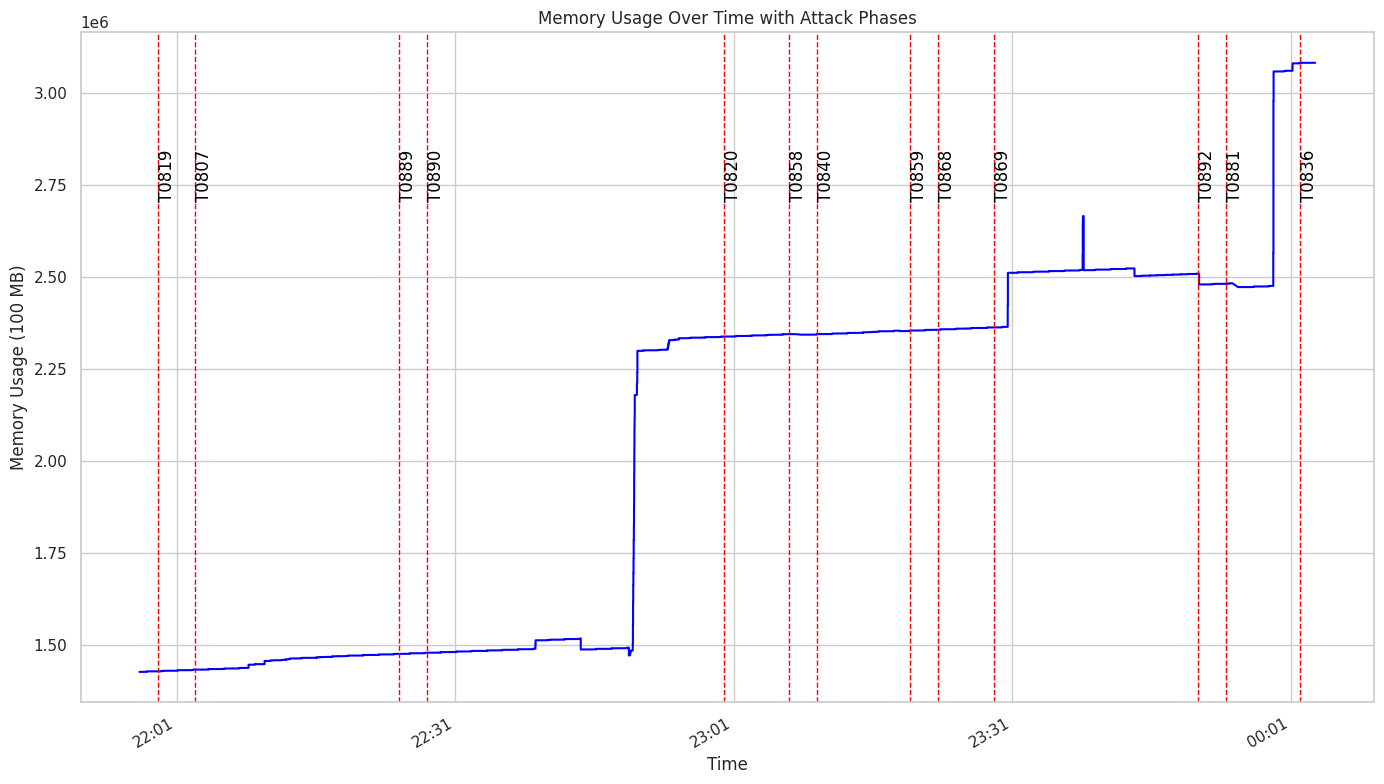

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Attack time frames, handling the date change at midnight
attack_timeframes = [
    ("2024-08-24 21:59", "2024-08-24 22:02", "T0819"),
    ("2024-08-24 22:03", "2024-08-24 22:24", "T0807"),
    ("2024-08-24 22:25", "2024-08-24 22:27", "T0889"),
    ("2024-08-24 22:28", "2024-08-24 22:59", "T0890"),
    ("2024-08-24 23:00", "2024-08-24 23:06", "T0820"),
    ("2024-08-24 23:07", "2024-08-24 23:09", "T0858"),
    ("2024-08-24 23:10", "2024-08-24 23:19", "T0840"),
    ("2024-08-24 23:20", "2024-08-24 23:22", "T0859"),
    ("2024-08-24 23:23", "2024-08-24 23:28", "T0868"),
    ("2024-08-24 23:29", "2024-08-24 23:50", "T0869"),
    ("2024-08-24 23:51", "2024-08-24 23:53", "T0892"),
    ("2024-08-24 23:54", "2024-08-25 00:01", "T0881"),
    ("2024-08-25 00:02", "2024-08-25 00:05", "T0836")
]

# Convert the 'datetime' column to actual datetime objects
df_logging_attack['datetime'] = pd.to_datetime(df_logging_attack['datetime'])

# Filter the data to only include entries from August 24 and 25, 2024
df_logging_attack = df_logging_attack[df_logging_attack['datetime'].dt.date.isin([pd.to_datetime('2024-08-24').date(), pd.to_datetime('2024-08-25').date()])]

# Smoothing function using rolling average (window size 10 for stronger smoothing)
df_logging_attack['smoothed_cpu_usage'] = df_logging_attack['cpu_usage'].rolling(window=1000, min_periods=1).mean()

# Plotting Memory usage with vertical lines for attack phases
def plot_performance_with_attacks(data, metric, ylabel, title, smoothing=False):
    plt.figure(figsize=(14, 8))

    # Apply smoothing if specified
    if smoothing:
        metric = 'smoothed_' + metric

    # Plot the performance metric over time
    plt.plot(data['datetime'], data[metric] / 100, label=f'{ylabel} Over Time', color='blue', linewidth=1.5)  # Convert to 100MB scale

    # Adding vertical lines and text annotations for attack timeframes
    for start_time, end_time, mitre_id in attack_timeframes:
        start_dt = pd.to_datetime(start_time)  # Convert to datetime
        plt.axvline(start_dt, color='red', linestyle='--', linewidth=1)
        plt.text(start_dt, data[metric].max() * 0.9 / 100, mitre_id, rotation=90, verticalalignment='center', color='black')

    # Formatting the x-axis for datetime with fewer ticks
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=30))  # Set a larger interval to reduce the number of ticks
    plt.gcf().autofmt_xdate()  # Auto format the x-axis labels to avoid overlap

    # Plot aesthetics
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot memory usage without smoothing (adjusted to show in 100MB scale)
plot_performance_with_attacks(df_logging_attack, 'memory_usage', 'Memory Usage (100 MB)', 'Memory Usage Over Time with Attack Phases', smoothing=False)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Dictionary to map attack technique numbers to names
technique_mapping = {
    0: "No Technique",
    1: "Exploit Public-Facing Application (T0819)",
    2: "Command-Line Interface (T0807)",
    3: "Modify Program (T0889)",
    4: "Exploit Privilege Escalation (T0890)",
    5: "Exploit for Evasion (T0820)",
    6: "Change Operating Mode (T0858)",
    7: "Network Connection Enumeration (T0840)",
    8: "Valid Accounts (T0859)",
    9: "Detect Operating Mode (T0868)",
    10: "Standard Application Layer Protocol (T0869)",
    11: "Change Credential (T0892)",
    12: "Service Stop (T0881)",
    13: "Modify Parameter (T0836)",
    14: "Loss of Control (T0827)"
}

# Attack time frames
attack_timeframes = [
    ("2024-08-24 21:59", "2024-08-24 22:02", 1),
    ("2024-08-24 22:03", "2024-08-24 22:24", 2),
    ("2024-08-24 22:25", "2024-08-24 22:27", 3),
    ("2024-08-24 22:28", "2024-08-24 22:59", 4),
    ("2024-08-24 23:00", "2024-08-24 23:06", 5),
    ("2024-08-24 23:07", "2024-08-24 23:09", 6),
    ("2024-08-24 23:10", "2024-08-24 23:19", 7),
    ("2024-08-24 23:20", "2024-08-24 23:22", 8),
    ("2024-08-24 23:23", "2024-08-24 23:28", 9),
    ("2024-08-24 23:29", "2024-08-24 23:50", 10),
    ("2024-08-24 23:51", "2024-08-24 23:53", 11),
    ("2024-08-24 23:54", "2024-08-24 23:59", 12),
    ("2024-08-25 00:00", "2024-08-25 00:05", 13)
]

# Create CPU usage by averaging 'cpu_1' and 'cpu_2'
df_logging_attack['cpu_usage'] = (df_logging_attack['Arp.Plc.Eclr/code.cpu_1'] + df_logging_attack['Arp.Plc.Eclr/code.cpu_2']) / 2

# Use the 'MEM_USED' column for memory usage
df_logging_attack['memory_usage'] = df_logging_attack['Arp.Plc.Eclr/code.USER_PART_DT.MEM_USED']

# Create an empty DataFrame to store max, mean, and added values for each technique
performance_stats = []

for start_time, end_time, technique in attack_timeframes:
    # Filter the dataset based on the start and end time for each technique
    mask = (df_logging_attack['datetime'] >= pd.to_datetime(start_time)) & (df_logging_attack['datetime'] <= pd.to_datetime(end_time))
    filtered_df = df_logging_attack[mask]

    if not filtered_df.empty:
        # Debugging to ensure correct timeframe range
        print(f"Technique: {technique_mapping[technique]} | Start: {start_time} | End: {end_time}")
        print(f"First timestamp: {filtered_df['datetime'].iloc[0]} | Last timestamp: {filtered_df['datetime'].iloc[-1]}")

        # Calculate max and mean values for CPU usage
        max_cpu = filtered_df['cpu_usage'].max()
        mean_cpu = filtered_df['cpu_usage'].mean()

        # Calculate the added memory usage (difference between last and first memory value)
        added_memory = filtered_df['memory_usage'].iloc[-1] - filtered_df['memory_usage'].iloc[0]

        # Store the results
        performance_stats.append({
            'Technique': technique_mapping[technique],
            'Max CPU Usage': max_cpu,
            'Mean CPU Usage': mean_cpu,
            'Added Memory Usage': added_memory  # Add the memory difference
        })

# Convert performance stats to DataFrame for easier visualization
performance_df = pd.DataFrame(performance_stats)

# Display the performance data
performance_df


Technique: Exploit Public-Facing Application (T0819) | Start: 2024-08-24 21:59 | End: 2024-08-24 22:02
First timestamp: 2024-08-24 21:59:00 | Last timestamp: 2024-08-24 22:02:00
Technique: Command-Line Interface (T0807) | Start: 2024-08-24 22:03 | End: 2024-08-24 22:24
First timestamp: 2024-08-24 22:03:00 | Last timestamp: 2024-08-24 22:24:00
Technique: Modify Program (T0889) | Start: 2024-08-24 22:25 | End: 2024-08-24 22:27
First timestamp: 2024-08-24 22:25:00 | Last timestamp: 2024-08-24 22:27:00
Technique: Exploit Privilege Escalation (T0890) | Start: 2024-08-24 22:28 | End: 2024-08-24 22:59
First timestamp: 2024-08-24 22:28:00 | Last timestamp: 2024-08-24 22:59:00
Technique: Exploit for Evasion (T0820) | Start: 2024-08-24 23:00 | End: 2024-08-24 23:06
First timestamp: 2024-08-24 23:00:00 | Last timestamp: 2024-08-24 23:06:00
Technique: Change Operating Mode (T0858) | Start: 2024-08-24 23:07 | End: 2024-08-24 23:09
First timestamp: 2024-08-24 23:07:00 | Last timestamp: 2024-08-24 23

,Technique,Max CPU Usage,Mean CPU Usage,Added Memory Usage
0,Exploit Public-Facing Application (T0819),89.0,17.508564,311296
1,Command-Line Interface (T0807),99.5,36.920731,4141056
2,Modify Program (T0889),98.5,16.766116,163840
3,Exploit Privilege Escalation (T0890),100.0,24.116879,85770240
4,Exploit for Evasion (T0820),99.0,21.511631,483328
5,Change Operating Mode (T0858),91.5,37.266467,-135168
6,Network Connection Enumeration (T0840),99.0,25.253744,815104
7,Valid Accounts (T0859),99.0,26.466088,188416
8,Detect Operating Mode (T0868),100.0,30.032890,499712
9,Standard Application Layer Protocol (T0869),100.0,22.291554,14520320
